Enter names of students working in a team of two here: [Tong Li] [Ning Liang]

# NUC Exercise #1 – SPECT and PET/CT

The purpose of the exercise is to calculate the spatial resolution resulting from collimation in SPECT, to reconstruct PET/CT in-vivo data and to implement CT-based attenuation correction of PET phantom data. For the latter task, the analytical computer model of the human thorax is extended to include an artificial lung tumor accumulating a radio tracer.

Some functionality that was implemented in the previous XCT exercise 1 is found in file `local_functions.py`. To use these functionalities the module `local_functions` is imported. Whenever you see a function call or the use of variables such as `local_functions.calculate_discrete_phantom(...)` have a look into the file to understand what the code is doing.

## Imports

In [14]:
from pint import Quantity
from typing import Tuple
from scipy.signal import convolve
from scipy.interpolate import griddata
from scipy.io import loadmat
from skimage.transform import radon, iradon

import numpy as np
import matplotlib.pyplot as plt
import local_functions

%matplotlib inline

from typing import List, Tuple
from types import SimpleNamespace
from pint import Quantity

## Section 1 - SPECT Pinhole

A pinhole SPECT camera is given consisting of a detector array with crystals of area of 2.8 mm x 2.8 mm. Between individual crystals there is a gap (insulation) of 0.2 mm. The distance between the detector array and the pinhole is 20 cm; the pinhole is assumed to be ideal, i.e. the thickness of the pinhole plate is negligible and attenuation of the pinhole material shall be infinite.

![figure1](figure1.png)

> Calculate at what distance x from the pinhole must the object be placed in order to achieve a spatial resolution (pixel dimension) of $r_s=0.6mm$ on the object surface? For an estimate assume the pinhole to be of radius 0. 

*Type your answer here*
$$4cm$$

> What is the spatial resolution $r_c$ at the center of a sample of a thickness of $y=40mm$? 

*Type your answer here*
$$0.9mm$$

> What is the actual $x$ if the actual diameter of the pinhole ($100\mu m$) is considered?

*Type your answer here*

$$32.3mm$$

## Section 2 - In-vivo PET-CT Data

In the current folder, you  will find a data file called **__InvivoData.mat__** which contains sinograms of a 18-FDG PET and a corresponding CT
scan of a human brain. The task is to reconstruct and compare the PET and the CT scans using code that was
previously used in the XCT exercises.

In [15]:
# Load the data
data = loadmat('InvivoData.mat')['invivo']

# Get projection angles
projection_angles = np.squeeze(data[0, 0][0])

# Get matrix size
matrix = np.squeeze(data[0, 0][1])
matrix = (matrix,matrix)

# Store PET sinograms
pet_sinogram = (data[0, 0][2]).T

# Store CT sinograms
ct_sinogram = (data[0, 0][3]).T

# Define ticks and label for image display
xticks = np.unique(np.concatenate([np.linspace(0, matrix[0]//2, 4), np.linspace(matrix[0]//2, matrix[0], 4)]))
yticks = np.unique(np.concatenate([np.linspace(0, matrix[1]//2, 4), np.linspace(matrix[1]//2, matrix[1], 4)]))
xtick_labels = [f"{t:1.0f}" for t in xticks - matrix[0]//2]
ytick_labels = [f"{t:1.0f}" for t in yticks - matrix[1]//2]

####  Task 2.1
> Reconstruct the in-vivo CT sinogram using filtered backprojection as developed in the XCT exercises!

/home/jovyan/assignments/nuc-1/local_functions.py:187: RuntimeWarning: overflow encountered in scalar negative
  filt = np.abs(np.arange(np.fix(-matrix[0] / 2), np.ceil(matrix[0] / 2)))


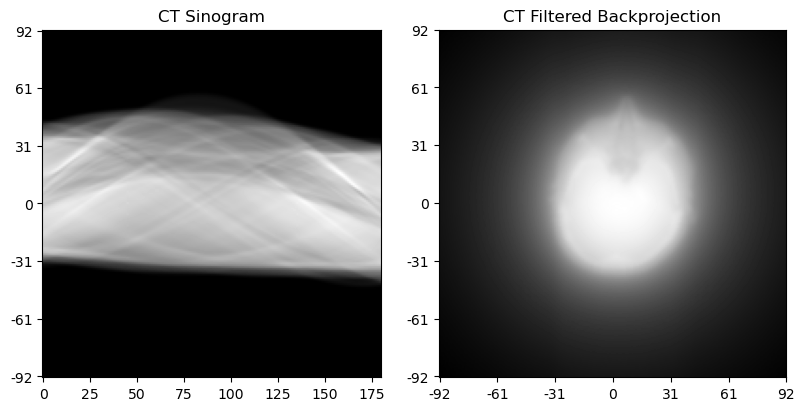

In [16]:
# TASK: Reconstruct CT data using filtered backprojection
ct_image = local_functions.filtered_back_projection(ct_sinogram, matrix, projection_angles)

# Plot sinograms and filtered backprojection
fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

# Set axis titles and ticks
axes[0].imshow(ct_sinogram.T, origin="lower", cmap="gray")
axes[0].set_yticks(yticks), axes[0].set_yticklabels(ytick_labels)
axes[0].set_title("CT Sinogram")

axes[1].imshow(ct_image, origin="lower", cmap="gray")
axes[1].set_yticks(yticks), axes[1].set_xticks(xticks);
axes[1].set_yticklabels(ytick_labels), axes[1].set_xticklabels(xtick_labels);
axes[1].set_title("CT Filtered Backprojection"); 

####  Task 2.2
> Reconstruct the in-vivo PET sinogram using filtered backprojection!

/home/jovyan/assignments/nuc-1/local_functions.py:187: RuntimeWarning: overflow encountered in scalar negative
  filt = np.abs(np.arange(np.fix(-matrix[0] / 2), np.ceil(matrix[0] / 2)))


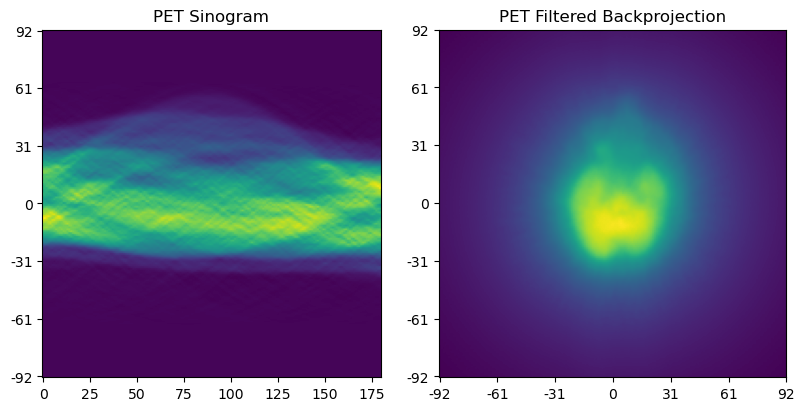

In [17]:
# TASK: Reconstruct PET data using filtered backprojection
pet_image = local_functions.filtered_back_projection(pet_sinogram, matrix, projection_angles)

# Plot sinograms and filtered backprojection
fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

# Set axis titles and ticks
axes[0].imshow(pet_sinogram.T, origin="lower")
axes[0].set_yticks(yticks), axes[0].set_yticklabels(ytick_labels)
axes[0].set_title("PET Sinogram")

axes[1].imshow(pet_image, origin="lower")
axes[1].set_yticks(yticks), axes[1].set_xticks(xticks);
axes[1].set_yticklabels(ytick_labels), axes[1].set_xticklabels(xtick_labels);
axes[1].set_title("PET Filtered Backprojection"); 

####  Task 2.3
> By comparing the PET and CT images, which brain areas are seen to accumulate the tracer primarily? What is the reason?

*Type your answer here* :
Cerebral Cortex.FDG accumulates in areas with high glucose metabolism.

## Section 3 - PET Tumor Activity

To study PET signals of a tumor, the synthetic analytical phantom as developed during the XCT exercises is
extended with a "lung tumor".

#### Task 3.1
> Update mass attenuation coefficients corresponding to PET photon energies; please refer to Tables 4 at https://www.nist.gov/pml/x-ray-mass-attenuation-coefficients

In [18]:
# Bone enhancement factor to improve visualization
bone_factor = 10

# Tissue densities
tissue_densities = dict(
    blood=Quantity(1.060, "g/cm**3"),
    bone=Quantity(1.450, "g/cm**3"),  
    lung=Quantity(0.001, "g/cm**3"),
    muscle=Quantity(1.050, "g/cm**3"),
    water=Quantity(1.000, "g/cm**3"), 
)

# Mass attenuation coefficients (100keV) 
mass_attenuation_coeffs_100keV = dict(
    blood=Quantity(0.149, "cm**2/g"),
    bone=Quantity(bone_factor*0.186, "cm**2/g"),
    lung=Quantity(0.154, "cm**2/g"),
    muscle=Quantity(0.169, "cm**2/g"),
    water=Quantity(0.171, "cm**2/g"),
)

# TASK: Mass attenuation coefficients (511keV) 
mass_attenuation_coeffs_511keV = dict(
    blood=Quantity(0.09598, "cm**2/g"), 
    bone=Quantity(bone_factor*0.09022, "cm**2/g"), 
    lung=Quantity(0.096, "cm**2/g"),  
    muscle=Quantity(0.09598, "cm**2/g"),  
    water=Quantity(0.09687, "cm**2/g"),  
)

In [19]:
# Compute linear attenuation coefficients
lin_attenuation_coeffs_100keV = {k: tissue_densities[k] * mass_attenuation_coeffs_100keV[k] for k in tissue_densities.keys()}
lin_attenuation_coeffs_511keV = {k: tissue_densities[k] * mass_attenuation_coeffs_511keV[k] for k in tissue_densities.keys()}

#### Task 3.2
> Implement an artificial lung tumor into the thorax phantom developed in the XCT exercises; assign a radioactivity of 300 MBq to the tumor (assuming it has accumulated large amounts of 18-FDG); all other organs and parts are assumed to take negligible amounts of the PET tracer!

In [20]:
# Linear attenuation coefficients (511keV) 
lin_dict = lin_attenuation_coeffs_511keV

# TASK: Define tumor activity in MBq 
tumor_activity = 300

# TASK: Define PET phantom
pet_phantom = [
        SimpleNamespace(x0=0, y0=0, a=90, b=80, theta=0, mue=lin_dict["bone"], act=Quantity(0, "MBq")),
        SimpleNamespace(x0=0, y0=0, a=70, b=60, theta=0, mue=lin_dict["lung"] - lin_dict["bone"], act=Quantity(0, "MBq")),
        SimpleNamespace(x0=110, y0=0, a=15, b=15, theta=0, mue=lin_dict["muscle"], act=Quantity(0, "MBq")),
        SimpleNamespace(x0=110, y0=0, a=5, b=5, theta=0, mue=lin_dict["bone"] - lin_dict["muscle"], act=Quantity(0, "MBq")),
        SimpleNamespace(x0=-110, y0=0, a=15, b=15, theta=0, mue=lin_dict["muscle"], act=Quantity(0, "MBq")),
        SimpleNamespace(x0=-110, y0=0, a=5, b=5, theta=0, mue=lin_dict["bone"] - lin_dict["muscle"], act=Quantity(0, "MBq")),
        SimpleNamespace(x0=0, y0=-20, a=10, b=10, theta=0, mue=lin_dict["blood"] - lin_dict["lung"], act=Quantity(0, "MBq")),
        SimpleNamespace(x0=30, y0=25, a=25, b=20, theta=35, mue=lin_dict["muscle"] - lin_dict["lung"], act=Quantity(0, "MBq")),
        SimpleNamespace(x0=-30, y0=0, a=10, b=10, theta=0, mue=lin_dict["muscle"] - lin_dict["lung"], act=Quantity(tumor_activity, "MBq")), 
    ]

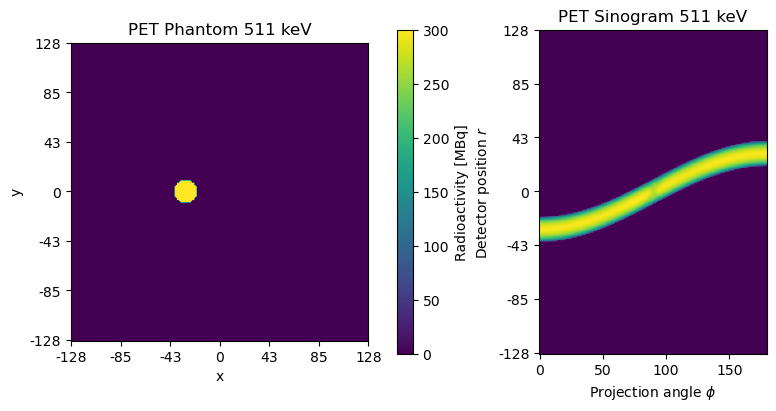

In [21]:
# Define projection angles, detector bins, image matrix size
projection_angles = np.arange(0, 180)
detector_bins = 256
matrix = (256, 256)

# Define ticks and label for image display
xticks = np.unique(np.concatenate([np.linspace(0, matrix[0]//2, 4), np.linspace(matrix[0]//2, matrix[0], 4)]))
yticks = np.unique(np.concatenate([np.linspace(0, matrix[1]//2, 4), np.linspace(matrix[1]//2, matrix[1], 4)]))
xtick_labels = [f"{t:1.0f}" for t in xticks - matrix[0]//2]
ytick_labels = [f"{t:1.0f}" for t in yticks - matrix[1]//2]

# TASK: Compute the discretized PET phantom
discretized_pet_phantom = local_functions.calculate_discrete_phantom(matrix, pet_phantom,"PET")

# TASK: Calculate sinogram of tumor only
tumor_index = 8
pet_sinogram = local_functions.calculate_pet_signal(detector_bins, projection_angles, pet_phantom, tumor_index)

# Plot phantom and sinograms 
fig, axes = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)

local_functions.display_phantom(discretized_pet_phantom, axes[0], fig, matrix, "PET")
axes[0].set_title("PET Phantom 511 keV")

axes[1].imshow(pet_sinogram.T, origin="lower")
axes[1].set_yticks(yticks), axes[1].set_yticklabels(ytick_labels)
axes[1].set_xlabel("Projection angle $\phi$"), axes[1].set_ylabel("Detector position $r$")
axes[1].set_title("PET Sinogram 511 keV");

#### Task 3.3
> Check the mean (radio)activity in the region-of-interest (ROI) of the tumor using local function `calculate_roi_signal`!

In [22]:
# TASK: Calculate mean activity of tumor in discretized PET phantom
tumor_activity_phantom = local_functions.calculate_roi_signal(pet_phantom, discretized_pet_phantom, tumor_index)

print(f"PET tumor activity in discretized phantom: {tumor_activity_phantom}");

PET tumor activity in discretized phantom: 300.0 megabecquerel


#### Task 3.4
> Reconstruct PET image from sinogram!

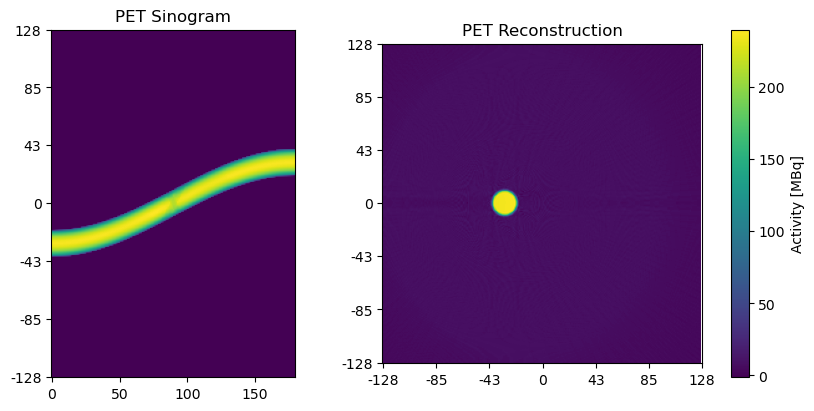

In [23]:
# TASK: Reconstruct PET image from sinogram
pet_image  = local_functions.filtered_back_projection(pet_sinogram, matrix, projection_angles)

# Plot sinograms and filtered backprojection
fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

axes[0].imshow(pet_sinogram.T, origin="lower")
axes[0].set_yticks(yticks), axes[0].set_yticklabels(ytick_labels)
axes[0].set_title("PET Sinogram")

artist = axes[1].imshow(pet_image, origin="lower")
axes[1].set_yticks(yticks), axes[1].set_xticks(xticks);
axes[1].set_yticklabels(ytick_labels), axes[1].set_xticklabels(xtick_labels);
axes[1].set_title("PET Reconstruction");
fig.colorbar(artist, ax=axes[1], label="Activity [MBq]");

> Check the mean (radio)activity in the region-of-interest (ROI) of the tumor using local function `calculate_roi_signal`!

In [24]:
# TASK: Calculate mean activity of tumor in PET image
tumor_activity_image = local_functions.calculate_roi_signal(pet_phantom, pet_image, tumor_index)

print(f"PET tumor activity in image: {tumor_activity_image}");

PET tumor activity in image: 236.10975370646227


> Why is there a larger discrepancy relative to ground truth?

*Type your answer here* ：The distance positron travels before annihilation is uncertain.The number of phton detected is less.

## Section 4 - Attenuation Correction
Implement a mapping from CT attenuation coefficients obtained at 100 keV (CT) to PET energy levels
(hint: use the difference of linear attenuation of bone and water to derive the conversion factor; approximate
the relation between linear attenuation coefficients of CT and PET energy levels using a linear function).

#### Task 4.1
> Derive an equation to perform PET attenuation correction based on converted CT linear attenuation coefficients.

*Type your answer here*
$$factor=\frac{\mu_{bone}^{511}-\mu_{water}^{511}}{\mu_{bone}^{100}-\mu_{water}^{100}}$$
$$factor = 0.477 \cdot \mu_{\text{CT}} $$
$$pet_{correct}=pet_{old}*e^{\mu *CT}$$

#### Task 4.2
> Implement mapping of CT sinogram data from 100 keV to 511 keV and apply attenuation correction to PET singram data!

In [25]:
# Linear attenuation coefficients (100keV) 
lin_dict = lin_attenuation_coeffs_100keV

# Define CT phantom
ct_phantom = [
        SimpleNamespace(x0=0, y0=0, a=90, b=80, theta=0, mue=lin_dict["bone"]),
        SimpleNamespace(x0=0, y0=0, a=70, b=60, theta=0, mue=lin_dict["lung"] - lin_dict["bone"]),
        SimpleNamespace(x0=110, y0=0, a=15, b=15, theta=0, mue=lin_dict["muscle"]),
        SimpleNamespace(x0=110, y0=0, a=5, b=5, theta=0, mue=lin_dict["bone"] - lin_dict["muscle"]),
        SimpleNamespace(x0=-110, y0=0, a=15, b=15, theta=0, mue=lin_dict["muscle"]),
        SimpleNamespace(x0=-110, y0=0, a=5, b=5, theta=0, mue=lin_dict["bone"] - lin_dict["muscle"]),
        SimpleNamespace(x0=0, y0=-20, a=10, b=10, theta=0, mue=lin_dict["blood"] - lin_dict["lung"]),
        SimpleNamespace(x0=30, y0=25, a=25, b=20, theta=35, mue=lin_dict["muscle"] - lin_dict["lung"]),
        SimpleNamespace(x0=-30, y0=25, a=10, b=10, theta=0, mue=lin_dict["muscle"] - lin_dict["lung"]), 
    ]

PET tumor activity in image after attenuation correction: 293.3692428313989


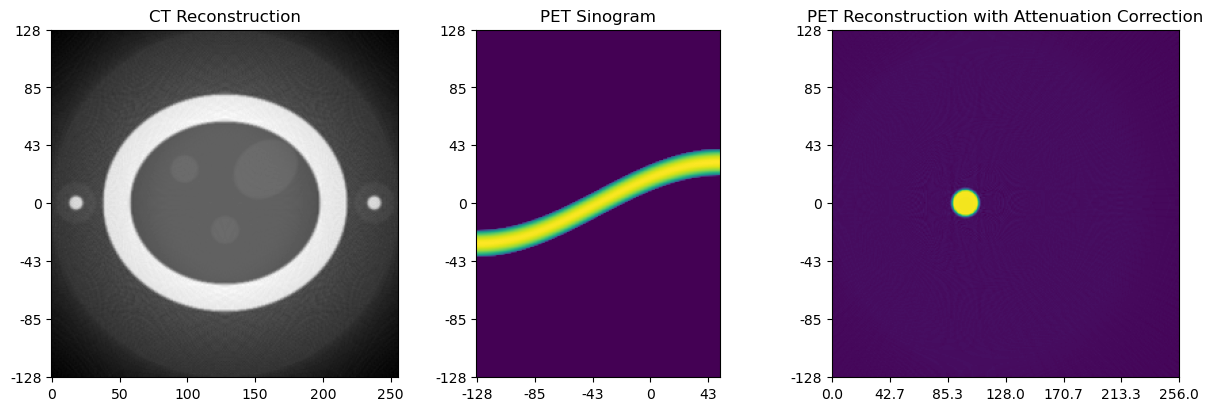

In [26]:
# Define projection angles, detector bins, image matrix size
projection_angles = np.arange(0, 180)
detector_bins = 256
matrix = (256, 256)

# Calculate CT sinogram
ct_sinogram = local_functions.calculate_line_integrals(detector_bins, projection_angles, ct_phantom)

# Reconstruct CT image
ct_image  = local_functions.filtered_back_projection(ct_sinogram, matrix, projection_angles)

# TASK: Factor to map from CT to PET photon energy
factor = 0.477

# TASK: Apply attenuation correction 
pet_sinogram = pet_sinogram*np.exp(factor*ct_sinogram)

# TASK: Reconstruct attenuation-corrected PET image
pet_image  = local_functions.filtered_back_projection(pet_sinogram, matrix, projection_angles)

# Plot sinograms and reconstructions
fig, axes = plt.subplots(1, 3, figsize=(12,4), constrained_layout=True)

axes[0].imshow(ct_image, origin="lower", cmap="gray")
axes[0].set_yticks(yticks), axes[1].set_xticks(xticks);
axes[0].set_yticklabels(ytick_labels), axes[1].set_xticklabels(xtick_labels);
axes[0].set_title("CT Reconstruction");

axes[1].imshow(pet_sinogram.T, origin="lower")
axes[1].set_yticks(yticks), axes[1].set_yticklabels(ytick_labels)
axes[1].set_title("PET Sinogram")

axes[2].imshow(pet_image, origin="lower")
axes[2].set_yticks(yticks), axes[2].set_xticks(xticks);
axes[2].set_yticklabels(ytick_labels), axes[1].set_xticklabels(xtick_labels);
axes[2].set_title("PET Reconstruction with Attenuation Correction");

# TASK: Calculate mean activity of tumor in PET image
tumor_activity_image = local_functions.calculate_roi_signal(pet_phantom,pet_image,tumor_index)
print(f"PET tumor activity in image after attenuation correction: {tumor_activity_image}");

#### Task 4.3
> Discuss potential difficulties of PET attenuation correction in clinical practice by considering the difference in
spatial resolution of CT and PET, differences in detector design and potential motion of the patient.

*Type your answer here* :Spatial resolution of PET is lower.The collimator is needed for PET before detector so there will be less photon arrive the detector.The time is proloned for PET due to scan different slices pf patient which increase the chance for patient movement. 